In [1]:
%pylab inline
from scipy.io import loadmat
import pandas as pd
from sklearn import cluster, decomposition, manifold, metrics, preprocessing

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist = loadmat("mnist-original")
X = mnist["data"].T[::50, :]
y = mnist["label"].T[::50]

In [3]:
X.shape

(1400, 784)

In [4]:
y.shape

(1400, 1)

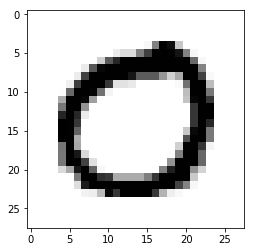

In [5]:
plt.imshow(X[42,:].reshape(28,28), cmap="binary")

## Exercice:

Pour cet exercice il vous est demandé :
- d’effectuer un partitionnement de X en 10 clusters, avec l’algorithme de clustering de votre choix
- de visualiser le résultat de ce clustering en deux dimensions (obtenues par exemple grâce à tSNE, après scaling des données)
- d’évaluer la qualité de ce partitionnement, d’une part intrinsèquement (sans utiliser y) et d’autre part en le comparant aux chiffres représentés par les images (en utilisant y).


In [6]:
stdScaler = preprocessing.StandardScaler()
X_scaled = stdScaler.fit_transform(X)

C:\Users\jdouet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\jdouet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Réduction des dimensions du problème

In [7]:
#Comme souvent dans les jeux d'images, beaucoup de features (pixels) ne contribuent pas, ou très peu à la variance
#du jeu de donnée, on peut donc les supprimer

In [8]:
pca = decomposition.PCA().fit(X_scaled)

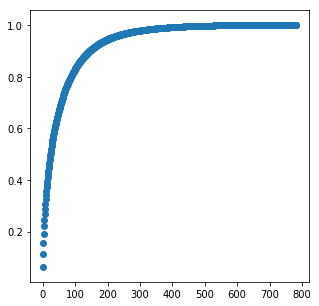

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(range(X_scaled.shape[1]),pca.explained_variance_ratio_.cumsum())

In [10]:
#on voit que plus de 90% de la variance est expliquée par les 200 premiers features, on décide donc de se limiter
#à ceux-ci pour la suite, pour réduire les temps de calcul (notamment pour le t-sne)
X_reduced = decomposition.PCA(n_components=200).fit_transform(X_scaled)
X_reduced.shape

(1400, 200)

### Partitionnement de X en 10 clusters

In [11]:
#puisque le nombre de clusters attendus est connu, on choisit d'utiliser l'algorithme de clustering KMeans

#éxécution de 10 algorithmes des Kmeans à partir de 10 centroides éparpillés dans l'espace de dimension réduite
clt = cluster.KMeans(n_clusters=10, n_init=10, init='k-means++').fit(X_reduced)

#éxécution de 10 algorithmes des Kmeans à partir de 10 centroides éparpillés dans l'espace total
clt_all_comp = cluster.KMeans(n_clusters=10, n_init=10, init='k-means++').fit(X_scaled)

#éxécution de 1 algorithme des Kmeans à partir de 10 centroides initialisés par PCA dans l'espace total
pca_init = decomposition.PCA(n_components=10).fit(X_scaled)
clt_pca_init = cluster.KMeans(n_clusters=10, n_init=1, init=pca_init.components_).fit(X_scaled) 

### Visualisation 2D du partitionnement

In [12]:
X_projections = []
perplexities = [10,30,50]
for perplexity in perplexities:
    tsne = manifold.TSNE(perplexity=perplexity, n_iter=5000)
    X_projections.append(tsne.fit_transform(X_reduced))

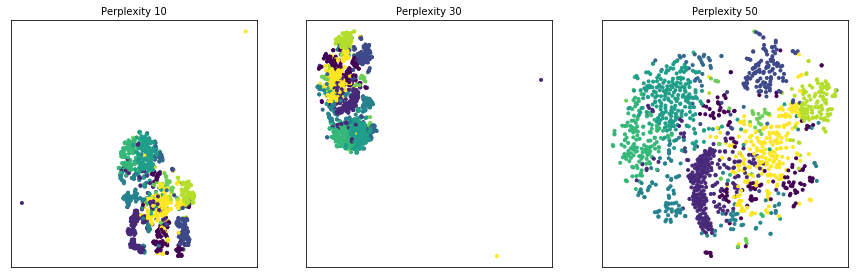

In [13]:
plt.figure(figsize=(15,10))
for i in range(len(perplexities)):
    plt.subplot(2,3,i+1)
    plt.scatter(X_projections[i][:,0],X_projections[i][:,1],c=clt.labels_, marker="." )
    title_text = 'Perplexity ' + str(perplexities[i])
    plt.title(title_text, size=10)
    plt.xticks(())
    plt.yticks(())

### Visualisation 2D avec labels

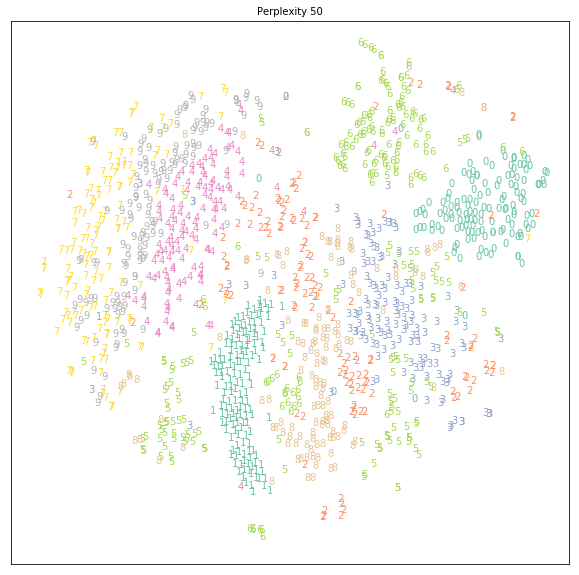

In [15]:
#on choisit une perplexité de 50 car c'est cette valeur qui donne la visualisation la plus probante dans notre cas
p = 2
plt.figure(figsize=(10,10))
plt.scatter(X_projections[p][:,0],X_projections[p][:,1], s=0)
title_text = 'Perplexity ' + str(perplexities[p])
plt.title(title_text, size=10)
plt.xticks(())
plt.yticks(())
for i, (x1,x2) in enumerate(zip(X_projections[p][:,0],X_projections[p][:,1])):
    plt.text(x1, x2, str('%d' % y[i,0]), color=plt.cm.Set2(y[i,0]/10.))

### Evaluations du partitionnement (intrinsèque par silhouette et comparaison avec labels)

In [19]:
#espace de dimension réduite
eval_intrinsic_silhouette =  metrics.silhouette_score(X_reduced, clt.labels_, metric='euclidean')
print("Coefficient de silhouette du partitionnement: ",eval_intrinsic_silhouette)
eval_label_rand = metrics.adjusted_rand_score(y[:,0], clt.labels_)
print("indice de Rand ajusté: ",eval_label_rand)

Coefficient de silhouette du partitionnement:  0.013423819311080908
indice de Rand ajusté:  0.3398173560197314


In [20]:
#espace total
eval_intrinsic_silhouette =  metrics.silhouette_score(X_scaled, clt_all_comp.labels_, metric='euclidean')
print("Coefficient de silhouette du partitionnement: ",eval_intrinsic_silhouette)
eval_label_rand = metrics.adjusted_rand_score(y[:,0], clt_all_comp.labels_)
print("indice de Rand ajusté: ",eval_label_rand)

Coefficient de silhouette du partitionnement:  0.011856846167596418
indice de Rand ajusté:  0.3236277058088142


In [21]:
#espace total, initialisation PCA
eval_intrinsic_silhouette =  metrics.silhouette_score(X_scaled, clt_pca_init.labels_, metric='euclidean')
print("Coefficient de silhouette du partitionnement: ",eval_intrinsic_silhouette)
eval_label_rand = metrics.adjusted_rand_score(y[:,0], clt_pca_init.labels_)
print("indice de Rand ajusté: ",eval_label_rand)

Coefficient de silhouette du partitionnement:  0.0055027533105707705
indice de Rand ajusté:  0.30861596719850115


### Les meilleures performances sont obtenues dans l'espace réduit avec initialisation par la méthode des k-means++ qui classe correctement un peu plus d'un tiers des données. 
### Ces performances ne sont malgré tout pas très bonnes (on aurait aimé des métriques plus proches de 1). Peut-être faut-il utiliser plus de données pour améliorer la résistance aux outliers?